# Image colorization using CNN

Cose da fare:
 - Trainare con tutto il dataset

In [ ]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import kornia

from statistics import mean
from skimage.color import rgb2lab

import time

from matplotlib.colors import LogNorm

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu

# Import and preprocess dataset (CIFAR10)
In this section, we import the dataset and process it properly. We discard the labels (we don't care about them since our goal is colorization, not classification) and set up a new dataset whose features are the L channel and whose labels are the AB channels. We then set up a Dataloader to process the data in batches.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Transform to LAB and separate the L and (a,b) channels
class RGB_to_LAB:
  def __call__(self, sample):
    # tensor = kornia.color.rgb_to_lab(sample) # 3 x 32 x 32
    tensor = rgb2lab(sample.numpy(), channel_axis=0) # 3 x 32 x 32
    tensor = torch.tensor(tensor)
    l = tensor[0, : , :]
    bw = torch.empty([3, 32, 32])
    bw[0, : , :] = l
    bw[1, : , :] = l
    bw[2, : , :] = 1
    return bw, tensor[1:, :, :]

#Function to switch back to rgb
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

transform_rgb_lab = RGB_to_LAB()
composed = transforms.Compose([transforms.ToTensor(), transform_rgb_lab])
# composed = transforms.Compose([transforms.ToTensor()])

In [ ]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = False,
                  transform = composed, train = True)

In [ ]:
#Remove labels from dataset
def discard_labels(data):
  return([datum[0] for datum in data])

dataset = discard_labels(dataset)

In [ ]:
#Separate the l and ab channels and store them as tensor

# dato = (l, ab)
def select_l(data):
  return([datum[0] for datum in data])
def select_ab(data):
  return([datum[1] for datum in data])

dataset_l =  select_l(dataset)
dataset_ab = select_ab(dataset)

#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_ab = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_ab])

## Distribution of (a,b)

In [ ]:
x = dataset_ab[:,0,:,:]#.reshape(1,-1)
x = torch.squeeze(x)

[-110.  -90.  -70.  -50.  -30.  -10.   10.   30.   50.   70.   90.  110.]
50000 

51200000.0 

Diff:  -51150000.0


<ipython-input-10-2b0bf6d9a568>:19: RuntimeWarning: divide by zero encountered in log
  hist_log = np.log((hist/np.sum(hist)))


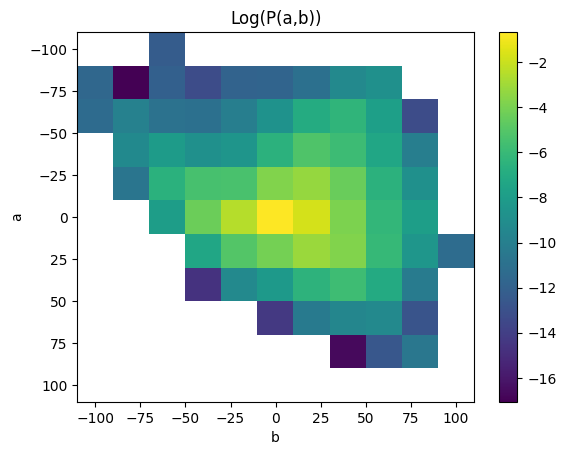

In [ ]:
a = dataset_ab[:,0,:,:].reshape(1,-1)
a = torch.squeeze(a).numpy()
b = dataset_ab[:,1,:,:].reshape(1,-1)
b = torch.squeeze(b).numpy()

# Define the limits for the x and y axes
x_min, x_max = -110, 110
y_min, y_max = -110, 110

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(a, b, bins=11, range=[[x_min, x_max], [y_min, y_max]])

print(xedges)

print(len(x), '\n')
print(np.sum(hist), '\n')
print('Diff: ', len(x) - np.sum(hist))

hist_log = np.log((hist/np.sum(hist)))

# Plot the histogram in logarithmic scale
plt.imshow(hist_log, interpolation='nearest', extent=[x_min, x_max, y_max, y_min], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('b')
plt.ylabel('a')
plt.title('Log(P(a,b))')
plt.show()

We now want to map each upperleft corner of a nonzero bin to its bin number

In [ ]:
Q = np.sum(np.isfinite(hist_log))
print("With our dataset we get Q = ", Q)

With our dataset we get Q =  69


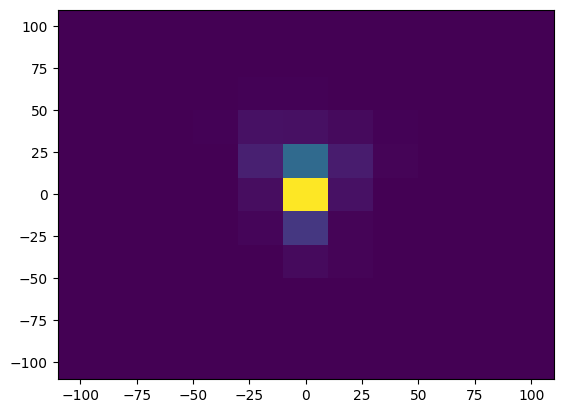

In [ ]:
hist_obj = plt.hist2d(a, b, bins = 11, range=[[x_min, x_max], [y_min, y_max]])

In [ ]:
#Keep track of where the grid points are
positions = []
indeces = []

index = 0

for i in range(len(hist_obj[1][:-1])):
  for j in range(len(hist_obj[2][:-1])):
    if hist_obj[0][i, j] > 0:
      positions.append((i,j))
      indeces.append(index)
      index += 1

dictionary = dict(zip(positions, indeces))
dictionary_inverse = dict(zip(indeces, positions)) # dictionary_inverse[132] --> (5, 7)

In [ ]:
dictionary.keys()

dict_keys([(1, 7), (1, 8), (1, 9), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (10, 2)])

## Store new dataset

In [ ]:
#Create ground truth Z_label

output_tensor = torch.zeros(50000, 1, 32, 32)

for image_number in range(dataset_ab.shape[0]):
  if image_number % 100 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 32, 32])
  image = dataset_ab[image_number, :, :, :]
  for i in range(32):
    for j in range(32):
#      print(image[:, i, j])
      couple = tuple(torch.Tensor.tolist(torch.Tensor.int((image[:, i,j] + torch.tensor([110, 110])) // 20)))
      index = dictionary[couple]
      Z_image[0, i, j] = index
  output_tensor[image_number, :, :, :] = torch.tensor(Z_image)

Image_nUmber :  0
Image_nUmber :  100
Image_nUmber :  200
Image_nUmber :  300
Image_nUmber :  400
Image_nUmber :  500
Image_nUmber :  600
Image_nUmber :  700
Image_nUmber :  800
Image_nUmber :  900
Image_nUmber :  1000
Image_nUmber :  1100
Image_nUmber :  1200
Image_nUmber :  1300
Image_nUmber :  1400
Image_nUmber :  1500
Image_nUmber :  1600
Image_nUmber :  1700
Image_nUmber :  1800
Image_nUmber :  1900
Image_nUmber :  2000
Image_nUmber :  2100
Image_nUmber :  2200
Image_nUmber :  2300
Image_nUmber :  2400
Image_nUmber :  2500
Image_nUmber :  2600
Image_nUmber :  2700
Image_nUmber :  2800
Image_nUmber :  2900
Image_nUmber :  3000
Image_nUmber :  3100
Image_nUmber :  3200
Image_nUmber :  3300
Image_nUmber :  3400
Image_nUmber :  3500
Image_nUmber :  3600
Image_nUmber :  3700
Image_nUmber :  3800
Image_nUmber :  3900
Image_nUmber :  4000
Image_nUmber :  4100
Image_nUmber :  4200
Image_nUmber :  4300
Image_nUmber :  4400
Image_nUmber :  4500
Image_nUmber :  4600
Image_nUmber :  4700
Imag

In [ ]:
#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_Z = torch.Tensor.int(output_tensor)

#Set up new dataset
N_images = 40000
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_Z[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_Z[N_images: ])

In [ ]:
#Save dataset so we won't have to compute it again
#serialized_dataset_path = '/content/drive/MyDrive/CIFAR10/train_small.pkl'
pickle.dump(train, open("df_small.pkl", "wb"))

pickle.dump(test, open("df_small_test.pkl", "wb"))

In [ ]:
!cp df_small.pkl gdrive/MyDrive/CIFAR10

In [ ]:
!cp df_small_test.pkl gdrive/MyDrive/CIFAR10

## Load new dataset

In [ ]:
objects = []
with (open("/content/gdrive/MyDrive/CIFAR10/df_small.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

with (open("/content/gdrive/MyDrive/CIFAR10/df_small_test.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break


In [ ]:
train = objects[0]
test = objects[1]

## Computation of $\vec{w}$

In [ ]:
#Store indeces as tensor

position_tensor = torch.zeros([len(hist_obj[1][:-1]), len(hist_obj[2][:-1])] )
for position, index in zip(positions, indeces):
  position_tensor[position[0], position[1]] = index

position_tensor = torch.Tensor.int(position_tensor)

In [ ]:
l = .5                                  # lambda
p = np.ndarray.flatten(hist_obj[0])
p = p[p > 0.]                           # p is a 1D array with the non-zero probabilities
p = p / np.sum(p)

Q = len(p)

w = 1 / ((1-l)*p + l/Q)
w = w / np.dot(w , p)

In [ ]:
#Plot w to check if it's ok
zeros = np.zeros((11, 11))
for i in range(len(w)):
  zeros[dictionary_inverse[i]] = w[i]

Text(0.5, 1.0, 'w values')

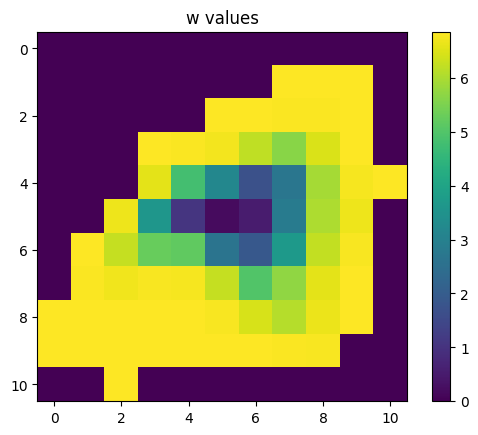

In [ ]:
im = plt.imshow(zeros)
plt.colorbar(im)
plt.title("w values")

## Training (special loss)
We train the network, using the following loss:

$L_{cl} = - \sum_{h,w, q} v(Z_{hw}) Z_{h,w,q}\log(\hat{Z}_{hwq})$,  $v(Z_{hw}) = w_{q^*}$, where $q^*$ is the index of the corresponding bin. We encode the ground truth $Z_{h,w,q}$ using one-hot-encoding.

*Reminder: Z has the shape of (1, h, w, q)*.

In [ ]:
#Data loader
batch_size = 200
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
w = torch.tensor(w)
w = w.clone().detach()

<ipython-input-34-09271d3c61f3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w)


In [ ]:
class network_model(nn.Module):
  def __init__(self):
    super(network_model, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False


    # define our layers on top of resnet <-- output: Qx32x32
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, Q, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(Q),
      nn.ReLU(),
      nn.Upsample(scale_factor = 4)
    )

  def forward(self, input):
    y = self.resnet_base(input) #first go through resnet
    z = self.cnn_next(y)        #then go through our layers
    return z

In [ ]:
network = network_model() #CNN
loss = nn.CrossEntropyLoss()       #We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=0.0)

In [ ]:
losses_train = []
losses_val = []

epochs = 20
patience = 5 #how many epochs of non decreasing validation we accept
min_val = 0 #minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)

v_prova = torch.ones([batch_size, 32, 32])

with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train() #Set it up for training
    i = 0
    ls = []
    for features, labels in train_loader:

      predictions = network(features)

      v = w[labels]

      zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64)
      one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

      L = loss(predictions, one_hot)
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1
    losses_train.append(mean(ls))

#########################################################################################

    #Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        prediction_val = network(features)

        v = w[labels]
        zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64)
        one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

        val_loss = loss(prediction_val, one_hot)
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      losses_val.append(mean(val_batches))

    #Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)

    #Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  5.005960882852489
Loss at iteration  50  is  3.8420408912485855
Loss at iteration  100  is  3.8036355952924943
Loss at iteration  150  is  3.5555625467434813
Loss at iteration  200  is  3.459863309097196
Loss at iteration  250  is  3.0801472300197643
Loss at iteration  300  is  3.3053552867132536
Loss at iteration  350  is  3.3346996065588064
At epoch  0  validation loss  3.3618967823626678
Epoch  1
Loss at iteration  0  is  3.037362227802861
Loss at iteration  50  is  3.586136055466379
Loss at iteration  100  is  3.1746723810428534
Loss at iteration  150  is  3.718387692378027
Loss at iteration  200  is  3.0198854186822848
Loss at iteration  250  is  3.269104865217764
Loss at iteration  300  is  3.5067229152797985
Loss at iteration  350  is  3.2849825173179807
At epoch  1  validation loss  3.1967060012794617
Epoch  2
Loss at iteration  0  is  2.8610681390441504
Loss at iteration  50  is  3.0019422008764987
Loss at iteration  100  is  2.64254931493193

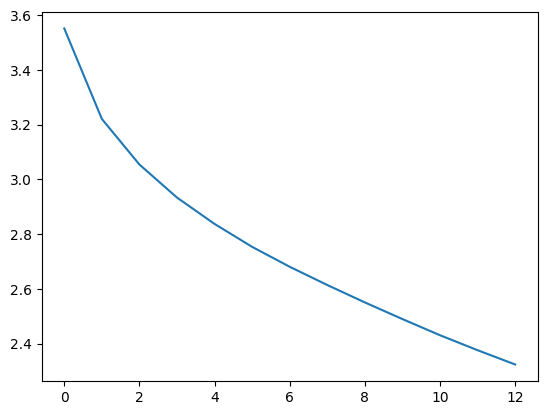

In [ ]:
plt.plot(losses_train)

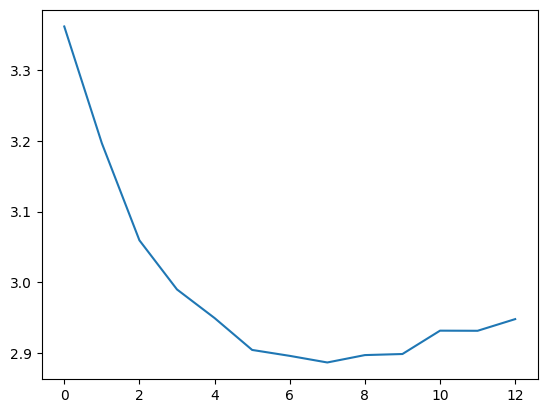

In [ ]:
plt.plot(losses_val)

## Display output

In [ ]:
input = test[-1][0]
output = network(torch.unsqueeze(input, 0))

In [ ]:
output = torch.squeeze(output, 0)

In [ ]:
#To go back from output to ab:

ab = torch.zeros(2, 32, 32)
ab_indeces = torch.zeros(2, 32, 32)

#take output and find maximum index along direction 3
argmax = torch.argmax(output, 0)
argmax = argmax.numpy()

print(argmax)

#find corresponding (i,j) using inverse dictionary
a_entries = np.zeros([32, 32])
b_entries = np.zeros([32, 32])

for i in range(32):
  for j in range(32):
    index = argmax[i,j]
    index = int(index)
    a = dictionary_inverse[index][0]
    b = dictionary_inverse[index][1]

    a = (a + .5)*20 - 110
    a_entries[i,j] = a

    b = (b + .5)*20 - 110
    b_entries[i,j] = b

ab[0, : , : ] = torch.tensor(a_entries)
ab[1, : , : ] = torch.tensor(b_entries)

[[26 26 26 ... 26 26 26]
 [26 26 26 ... 26 26 26]
 [26 26 26 ... 26 26 26]
 ...
 [27 27 27 ... 26 26 26]
 [27 27 27 ... 26 26 26]
 [27 27 27 ... 26 26 26]]


In [ ]:
rgb_attempt = LAB_to_RGB(torch.squeeze(input)[0, : , :], ab)

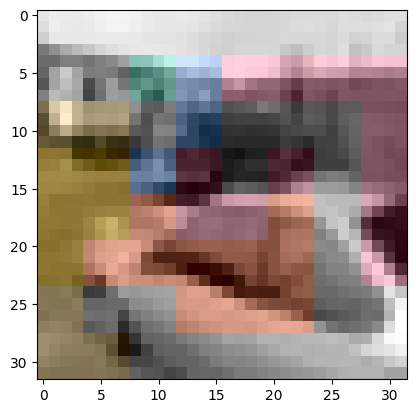

In [ ]:
plt.imshow(torch.permute(rgb_attempt, [1,2,0]))

# High res image

In [ ]:
from PIL import Image
image_adress = '/content/flowers.jpeg'
image_original = Image.open(image_adress)

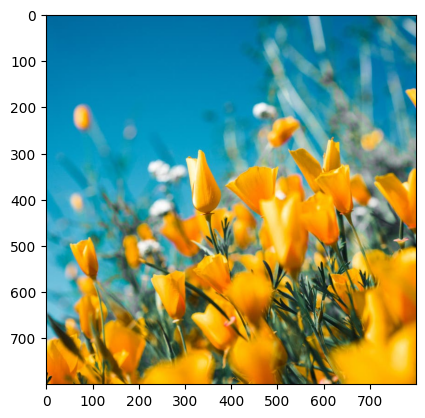

In [ ]:
plt.imshow(image_original)

In [ ]:
image_rgb = np.array(image_original)
image_lab = rgb2lab(image_rgb)
image_lab = torch.tensor(image_lab)

In [ ]:
image_lab = torch.permute(image_lab, [2, 0, 1])
image_lab.shape

torch.Size([3, 800, 800])

In [ ]:
bw = torch.zeros([3, 800 ,800])
bw[0, :, : ] = image_lab[0, :, :]
bw[1, :, : ] = image_lab[0, :, :]
bw[2, :, : ] = image_lab[0, :, :]

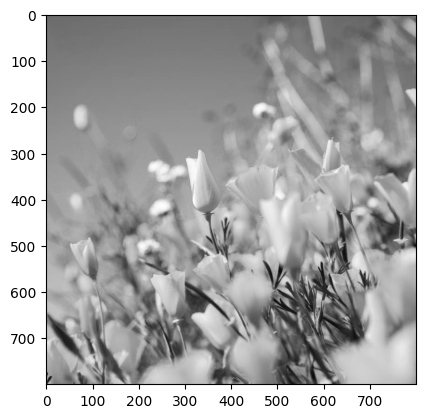

In [ ]:
plt.imshow(torch.permute(bw/100, [1, 2, 0]).numpy())

In [ ]:
network.eval()
output = network(torch.unsqueeze(bw, 0))

In [ ]:
#To go back from tensor to ab